In [20]:
import tensorflow.keras as keras
import json
from preprocessing import SEQUENCE_LEN, MAP_PATH
import numpy as np
from tensorflow.keras.optimizers.legacy import Adam
import music21 as m21


[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 9, 4, 4, 4, 30, 4, 31, 4, 13]
1/1 [==============================] - 0s 10ms/step
['72', '_', '_', '_', '67', '_', '64', '_', '71', '_', '_', '_', '67', '_', '64', '_', '69', '_', '72', '_', 'r', '_', '_', '_', 'r', '_', '_', '_', '_', '_', '_', '_', 'r', '_', '_', '_', '_', '_', '_', '_', 'r', '_', '_', '_', 'r', '_', '63', '_', '64', '_', '67', '_', '65', '_', '64', '_', '62', '_', '61', '_', '64', '_', '67', '_', '70', '_', '69', '_', '67', '_', '65', '_', '62', '_', '64', '_', '67', '_', '64', '_', '65', '_', '67', '_', '64', '_', '60', '_', '62', '_', '60', '_', '61', '_', '62', '_', '60', '_', '59', '_', '60', '_', '62', '_', '64', '_', '65', '_', '67', '_', '64', '_', '65', '_', '67', '65', '64', '_', '60', '_', '62', '_', '58', '_', '58', '_', '69', '_', '69', '_', '_', '_', '65', '_', '6

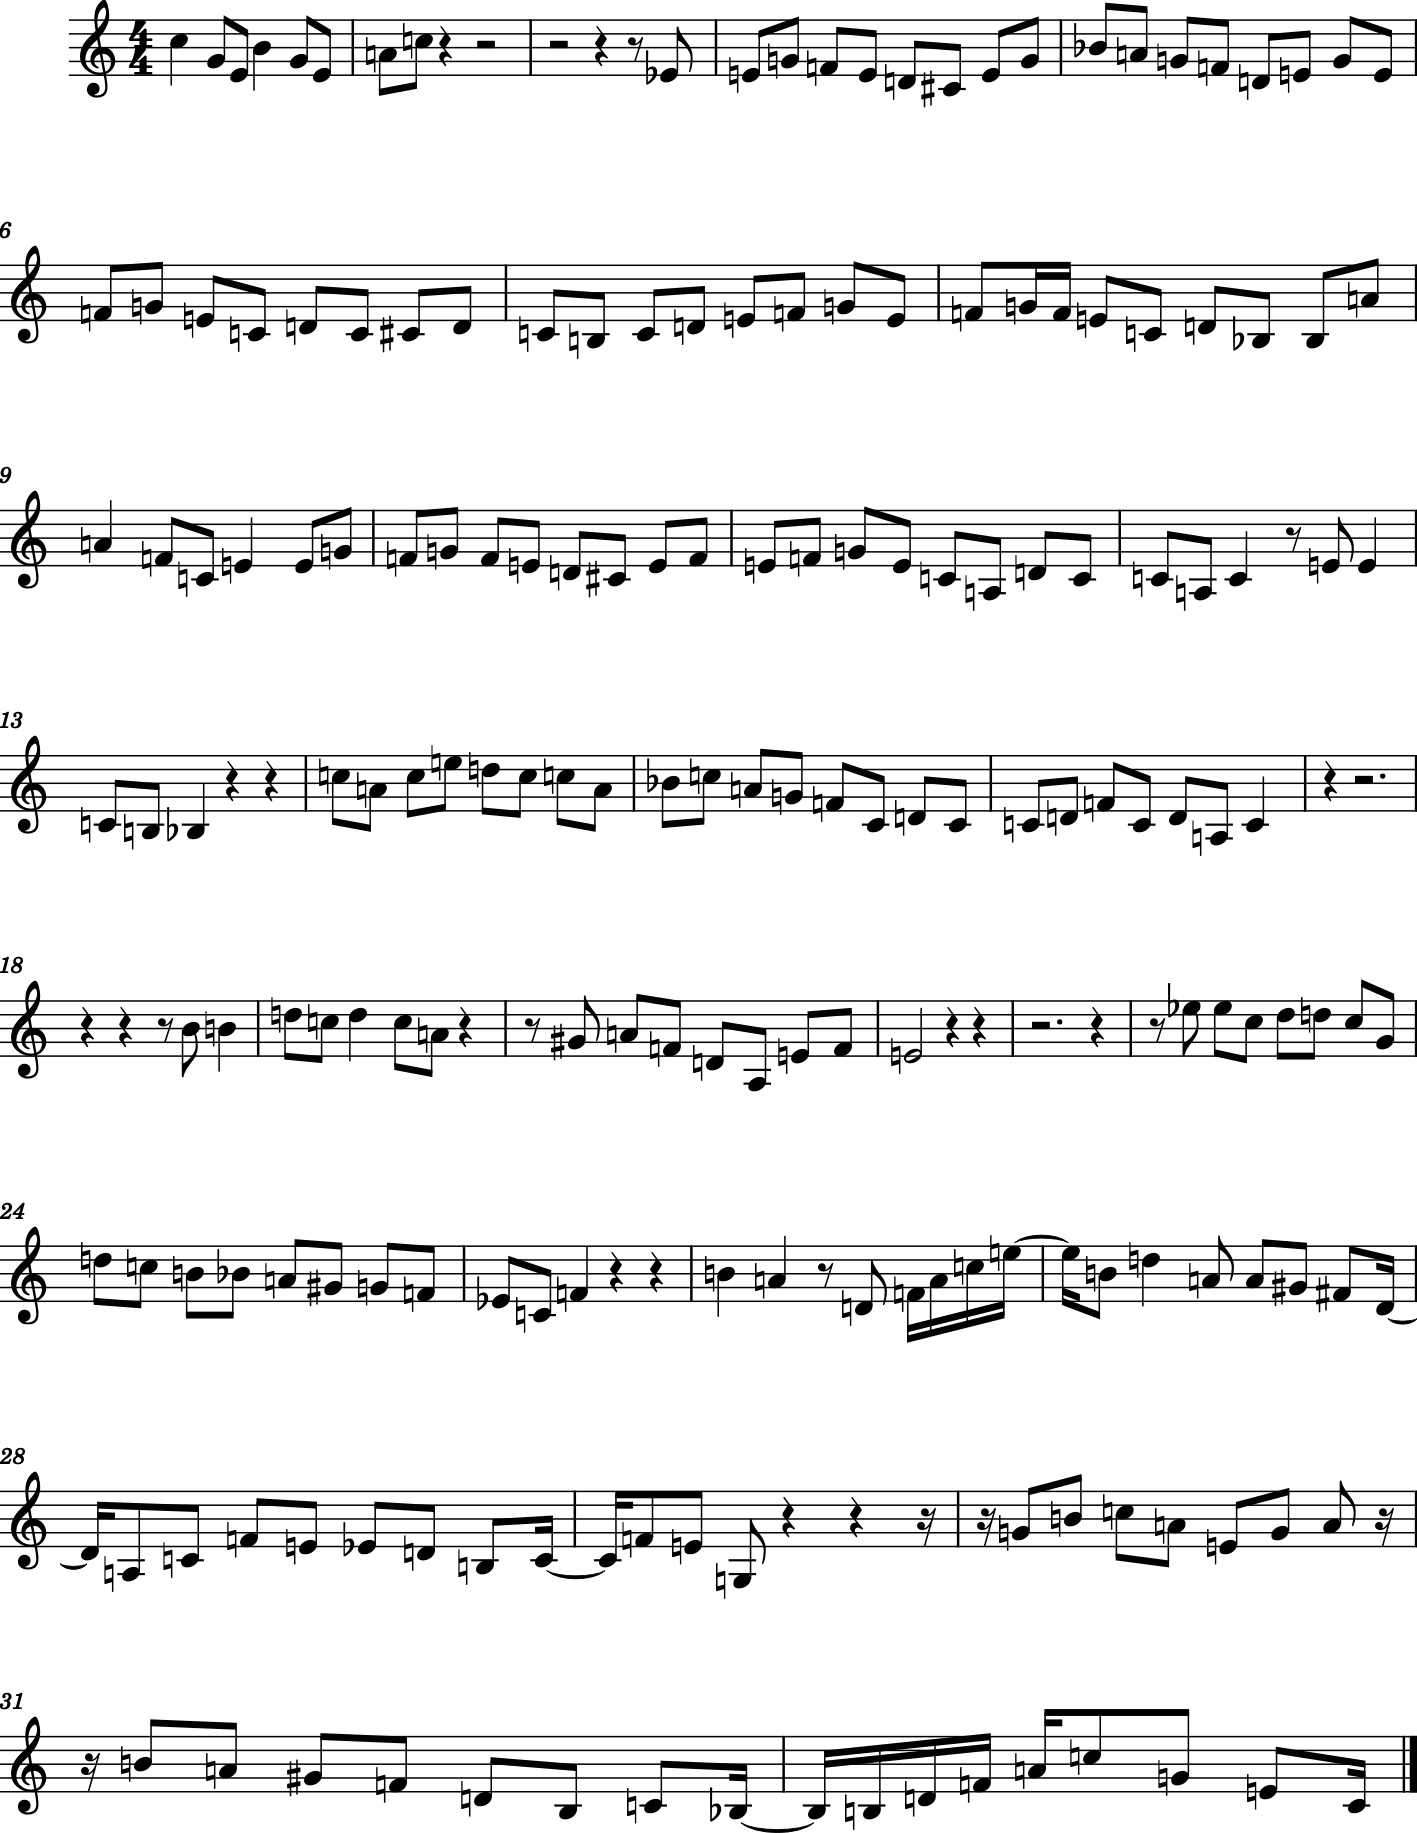

In [25]:
class improvGenerator():
    def __init__(self, model_path="model.keras"):
        self.model_path = model_path
        self.model = keras.models.load_model(model_path, compile=False)  # Load without compiling

        # Recompile the model using the legacy optimizer
        self.model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy')

        with open(MAP_PATH, "r") as fp:
            self._mappings = json.load(fp)
        self._start_symbols = ["/"] * SEQUENCE_LEN
    
    def generate_improv(self, seed, num_steps, max_sequence_length, temperature):
        seed = seed.split()

        improv = seed
        seed = self._start_symbols + seed

        seed = [self._mappings.get(syb) for syb in seed]
        print(seed)

        for _ in range(num_steps):
            #stops at max seq length
            seed = seed[-max_sequence_length:]

            encode_seed = keras.utils.to_categorical(seed, num_classes=len(self._mappings))
            encode_seed = encode_seed[np.newaxis,...]

            distribution = self.model.predict(encode_seed)[0]

            output_int = self._sample_with_temperature(distribution, temperature)

            seed.append(output_int)

            #map back
            output_syb = [k for k, v in self._mappings.items() if v == output_int]
            output_syb = output_syb[0]
            if output_syb == '/':
                break
            improv.append(output_syb)

        return improv

    def _sample_with_temperature(self, distribution, temperature):

        pred = np.log(distribution)/temperature
        distribution = np.exp(pred) / np.sum(np.exp(pred))

        choices = range(len(distribution))
        ind = np.random.choice(choices, p=distribution)

        return ind
    
    def save_improv(self, improv, step_duration=0.25, format='midi', file_name="file.midi"):

        stream = m21.stream.Stream()

        start_syb = None
        step_count = 1

        for i, syb in enumerate(improv):
            if syb != "_" or i+1 == len(improv ):
                if start_syb is not None:
                    q_length = step_duration*step_count 

                    if start_syb == "r":
                        m21_event = m21.note.Rest(quarterLength=q_length)
                    else:
                        m21_event = m21.note.Note(int(start_syb), quarterLength = q_length)
                    stream.append(m21_event)

                    step_count=1

                start_syb=syb


            else: step_count+=1
        stream.write(format, file_name)

        return stream

ig = improvGenerator()
seed = "72 _ _ _ 67 _ 64 _ 71" 

line = ig.generate_improv(seed, 500, SEQUENCE_LEN, 0.7)
stm = ig.save_improv(line)
print(line)
stm.show()

